In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [4]:
data = pd.read_csv('/content/smart_grid_stability_augmented.csv')

In [5]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [6]:
# Check for missing values and handle them
print(data.isnull().sum())
data.dropna(inplace=True)

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64


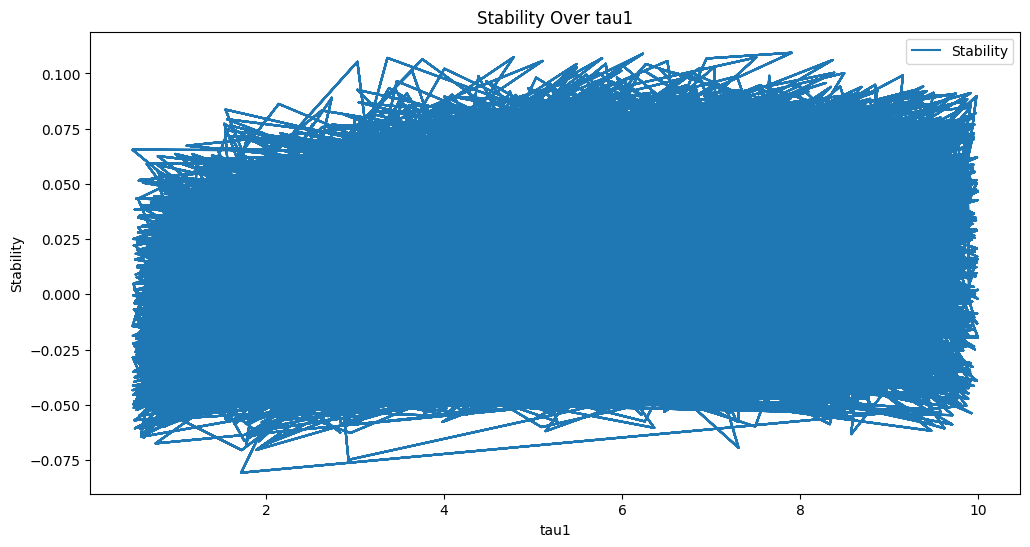

In [7]:
# 2. Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(data['tau1'], data['stab'], label='Stability')
plt.title('Stability Over tau1')
plt.xlabel('tau1')
plt.ylabel('Stability')
plt.legend()
plt.show()

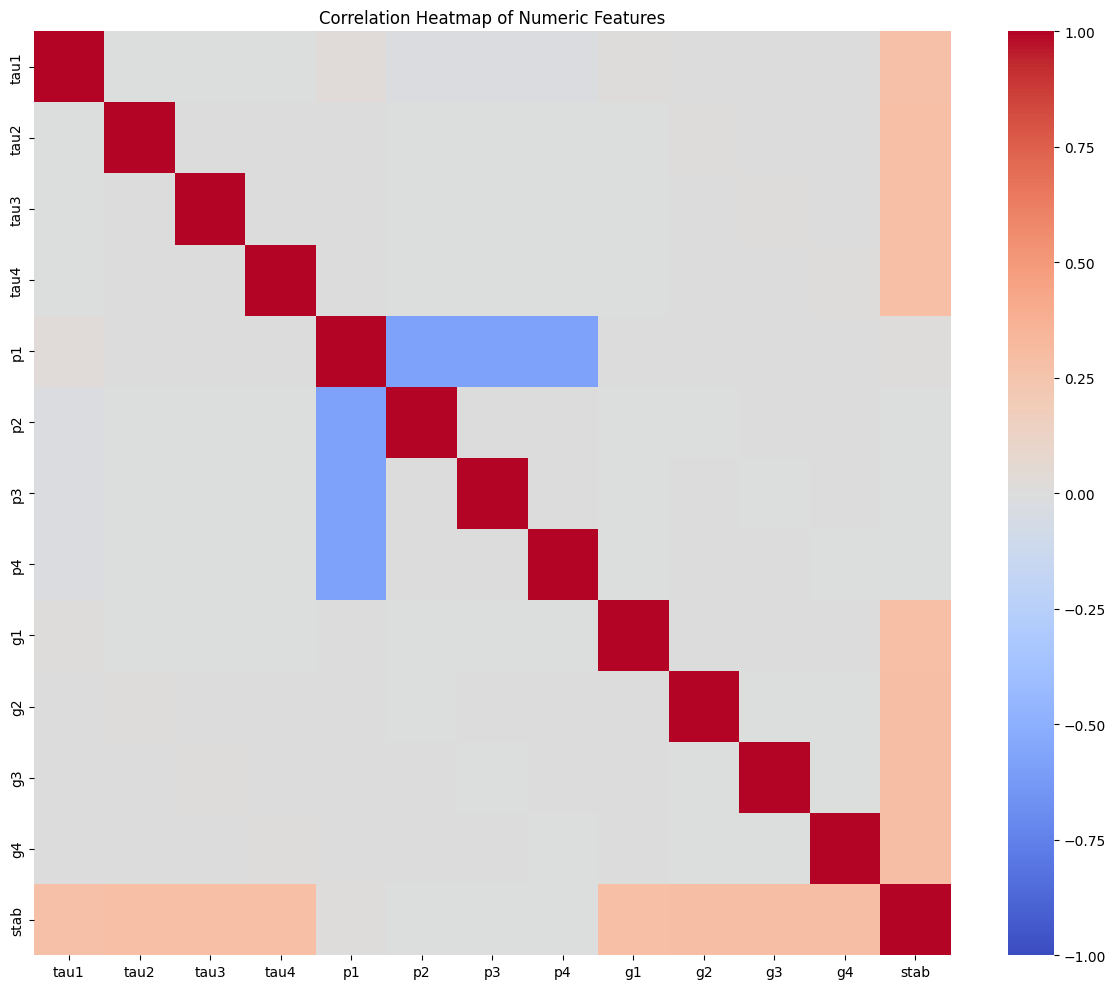

In [8]:
# Identify numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Create correlation matrix using only numeric columns
correlation_matrix = data[numeric_columns].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


In [9]:
# 3. Feature Engineering
data['tau_sum'] = data[['tau1', 'tau2', 'tau3', 'tau4']].sum(axis=1)
data['p_sum'] = data[['p1', 'p2', 'p3', 'p4']].sum(axis=1)
data['g_sum'] = data[['g1', 'g2', 'g3', 'g4']].sum(axis=1)

In [10]:
# Anomaly Detection
def detect_outliers(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column]))
    outliers = data[z_scores > threshold]
    return outliers

outliers = detect_outliers(data, 'stab')
print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 0


In [11]:
# Handle outliers (example: cap them)
data['stab'] = data['stab'].clip(lower=data['stab'].quantile(0.01), upper=data['stab'].quantile(0.99))

In [12]:
# 4. Model Selection and Development
X = data[['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4']]
y = data['stab']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# ARIMA Model
arima_model = ARIMA(y_train, order=(5,1,0))
arima_results = arima_model.fit()
arima_forecast = arima_results.forecast(steps=len(y_test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [18]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

In [19]:
# 5. Model Training and Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

evaluate_model(y_test, arima_forecast, "ARIMA")
evaluate_model(y_test, rf_predictions, "Random Forest (Tuned)")

ARIMA - MAE: 0.0333, MSE: 0.0016, RMSE: 0.0395
Random Forest (Tuned) - MAE: 0.0066, MSE: 0.0001, RMSE: 0.0088


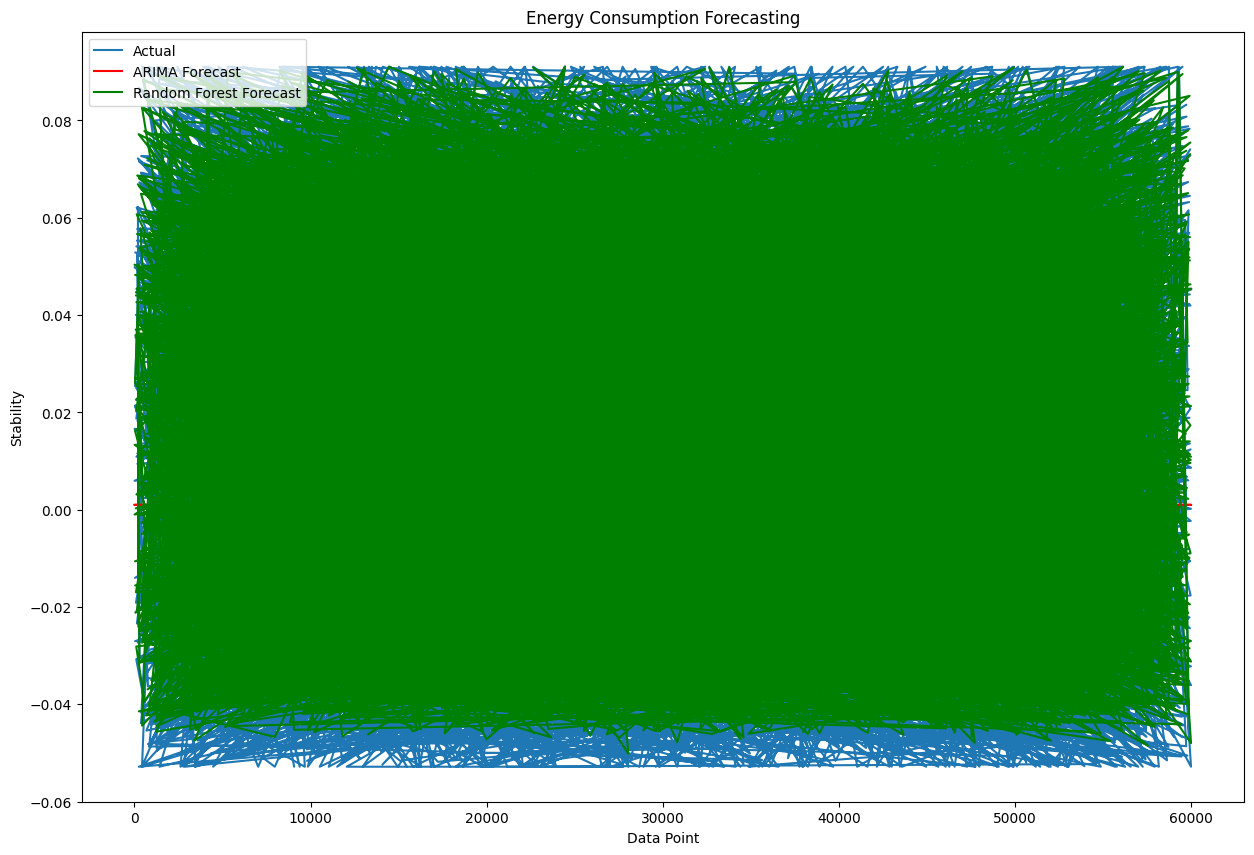

In [22]:
# 6. Forecasting and Visualization
plt.figure(figsize=(15, 10))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(y_test.index, rf_predictions, label='Random Forest Forecast', color='green')
plt.title('Energy Consumption Forecasting')
plt.xlabel('Data Point')
plt.ylabel('Stability')
plt.legend()
plt.show()

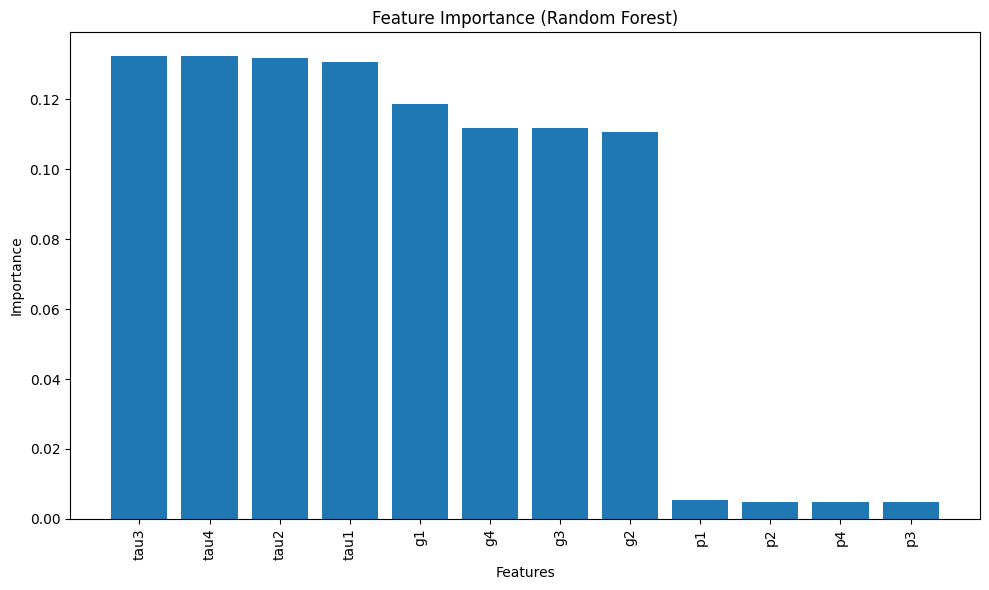

In [23]:
# Feature Importance (for Random Forest)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
